# Time Series Classification
**Content:**
- Google Colab Setup
- Preprocessing
- Modeling
- Evaluation
- Conclusion

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
# !pip install pmdarima

## I. Google Colab Setup

In [2]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pickle import dump, load

# Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
from sklearn.model_selection import GridSearchCV

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file and pre-written pyfile
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## II. Preprocessing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.7945,23.8614,23.7898,23.7945,205800,0.0000,0.0000,VNQ
1,2004-09-30,23.8661,24.0237,23.8614,23.9855,27900,0.0000,0.0000,VNQ
2,2004-10-01,24.0332,24.4628,23.9855,24.4294,129800,0.0000,0.0000,VNQ
3,2004-10-04,24.5296,24.6060,24.5296,24.5344,8100,0.0000,0.0000,VNQ
4,2004-10-05,24.5344,24.5821,24.5105,24.5296,11900,0.0000,0.0000,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.2800,9.2900,9.2200,9.2200,5200,0.0000,0.0000,REK
53435,2021-06-18,9.3300,9.3700,9.2700,9.3700,22800,0.0000,0.0000,REK
53436,2021-06-21,9.3200,9.3200,9.1700,9.1700,22900,0.0000,0.0000,REK
53437,2021-06-22,9.1600,9.2300,9.1600,9.2200,6200,0.0000,0.0000,REK


In [9]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

In [10]:
vnq.shape

(4213, 9)

In [11]:
# Drop unnecessary columns
vnq.drop(columns=['Volume', 'Dividends', 'Stock Splits', 'Ticker'], inplace=True)

In [12]:
# Shift index by 1 period => lag-1
vnq['Lag 1'] = vnq['Close'].shift(periods=1)

In [13]:
# Find the difference between closing price and lag-1
# Positive results => up trend
# Negtive (or 0) result => down trend
vnq.loc[vnq['Close'] - vnq['Lag 1'] > 0, 'Trend'] = 'up'
vnq.loc[vnq['Close'] - vnq['Lag 1'] <= 0, 'Trend'] = 'down'

In [14]:
vnq['Trend'].isna().sum() # The 1st row should have a null value

1

In [15]:
# Drop the "Lag 1" column
vnq.drop(columns=['Lag 1'], inplace=True)

# Drop the 1st row which has a null value
vnq.drop([0], inplace=True)

In [16]:
# Set the "Date" column as the index 
ut.preprocess_df(vnq)

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2004-09-30,23.8661,24.0237,23.8614,23.9855,up
2004-10-01,24.0332,24.4628,23.9855,24.4294,up
2004-10-04,24.5296,24.6060,24.5296,24.5344,up
2004-10-05,24.5344,24.5821,24.5105,24.5296,down
2004-10-06,24.5821,24.6442,24.5774,24.6442,up
...,...,...,...,...,...
2021-06-17,103.4100,103.7000,102.8600,103.5500,down
2021-06-18,103.0200,103.4700,101.7900,101.7900,down
2021-06-21,102.3100,104.2100,101.8000,103.8900,up


In [17]:
vnq['Trend'].unique()

array(['up', 'down'], dtype=object)

In [18]:
vnq['Trend'].value_counts()

up      2264
down    1948
Name: Trend, dtype: int64

In [19]:
# Label encoding
label_encoder = LabelEncoder()
vnq['Trend']= label_encoder.fit_transform(vnq['Trend'])

In [20]:
vnq['Trend'].value_counts()

1    2264
0    1948
Name: Trend, dtype: int64

### Train-Val-Test

In [21]:
# Split the data into train, val and test set
# Test size = 1 month (22 days)
# Val size = 1 year (253 days)
# Train size = rest of the time
train = vnq.iloc[:-275]
val = vnq.iloc[-275:-22]
test = vnq.iloc[-22:]

In [22]:
def xy_split(dataset):
    '''
    Split the dataset into X-part and y-part(label).

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Input:
    - dataset: dataframe

    Return:
    - X, y
    
    '''

    X = dataset.drop(columns=['Trend'], axis=1)
    y = dataset['Trend']

    return X, y

In [23]:
X_train, y_train = xy_split(train)
X_val, y_val = xy_split(val)
X_test, y_test = xy_split(test)

### Pipeline

In [24]:
num_cols = vnq.columns[:-1].tolist()
num_cols

['Open', 'High', 'Low', 'Close']

In [25]:
# Set up scaling step
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])  

# Put scaling step into a Column Transformer
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols)])

## III. Modeling
Metrics used:
- Accuracy
- ROC-AUC
- Classification Report
- Confusion Matrix
- ROC Curve

### Baseline Model
- Logistic Regression
    - Use a sigmoid function to transform the result between 0 and 1
    - p < 0.5 = 0
    - p ≥ 0.5 => 1

Train
-*-*-*-*-*-*-*-*
accuracy: 0.5438
roc-auc: 0.7147 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.5731
roc-auc: 0.8933


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.57      1.00      0.73       145

    accuracy                           0.57       253
   macro avg       0.29      0.50      0.36       253
weighted avg       0.33      0.57      0.42       253



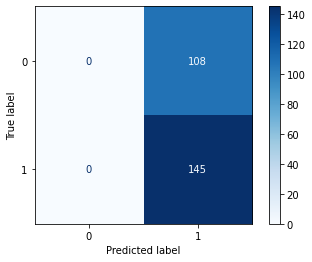

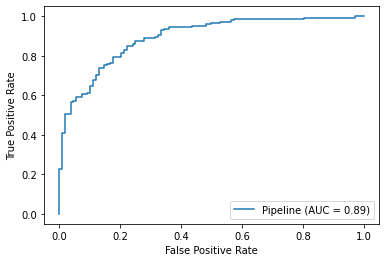

([0.5438], [0.5731], [0.7147], [0.8933])

In [26]:
lg_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(random_state=24))])

lg_clf.fit(X_train, y_train)

lg_result = ut.class_model_evaluation(lg_clf, X_train, y_train, X_val, y_val, use_decision_function='yes')
lg_result

>**Comment:** *Logistic Regression (Baseline Model)*
- Val accuracy 0.5731 is higher than train accuracy 0.5438 => slightly underfit
- F1-score (0.00 and 0.73) indicates the model can not classify the downtrend
- Although the roc-score is 0.89 which is relative high, the confusion matrix (TN is 0) indicates that the model is unable to detect the down pattern
    - Logistic regression thinks the price will always increase haha :)

### KNN
- KNN takes a point, calculates the distaces between that point and every single point in the training set, and finds the k nearest neighbors to examine the label

Train
-*-*-*-*-*-*-*-*
accuracy: 0.8890
roc-auc: 0.9541 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.7708
roc-auc: 0.8355


              precision    recall  f1-score   support

           0       0.78      0.65      0.71       108
           1       0.77      0.86      0.81       145

    accuracy                           0.77       253
   macro avg       0.77      0.76      0.76       253
weighted avg       0.77      0.77      0.77       253



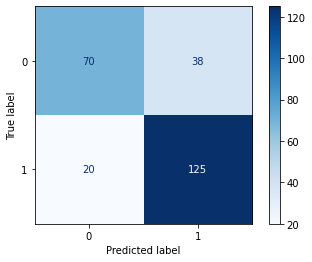

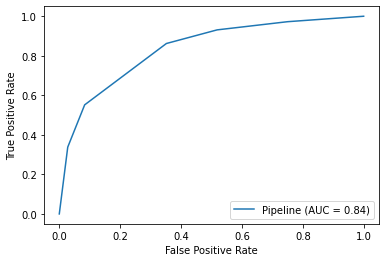

([0.889], [0.7708], [0.9541], [0.8355])

In [27]:
knn_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', KNeighborsClassifier())])

knn_clf.fit(X_train, y_train)

knn_result = ut.class_model_evaluation(knn_clf, X_train, y_train, X_val, y_val, use_decision_function='no')
knn_result

>**Comment:** *KNN*
- Val accuracy 0.7708 is lower than train accuracy 0.8890 = > overfit
- Model able to classfify the uptrend/downtrend, better than the baseline model
- Improve on f1-score (0.71 and  0.78) but still have some misclassify points
- ROC-score is 0.84 which is relative high

### Tree
- Strong learners

#### Random Forest
- Use ensemble of decision trees
- Use greedy algorithm 
    - Pros: maximizes information at every step
    - Cons: trees trained on the same dataset will generate exact same answer (lack of randomness)

Train
-*-*-*-*-*-*-*-*
accuracy: 1.0000
roc-auc: 1.0000 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.7352
roc-auc: 0.8113


              precision    recall  f1-score   support

           0       0.67      0.76      0.71       108
           1       0.80      0.72      0.76       145

    accuracy                           0.74       253
   macro avg       0.73      0.74      0.73       253
weighted avg       0.74      0.74      0.74       253



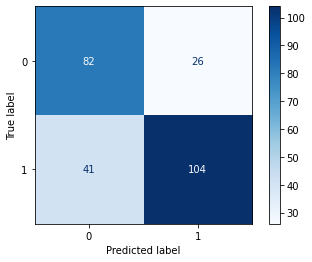

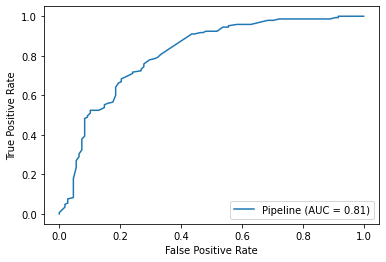

([1.0], [0.7352], [1.0], [0.8113])

In [28]:
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(criterion='entropy', random_state=24))])

rf_clf.fit(X_train, y_train)

rf_result = ut.class_model_evaluation(rf_clf, X_train, y_train, X_val, y_val, use_decision_function='no')
rf_result

>**Comment:** *Random Forest*
- Val accuracy 0.7352 is lower than train accuracy 1.0000 = > super overfit
- Model is able to classify the uptrend/downtrend, better than the baseline model
- F1-score (0.71 and 0.76), slightly worse than KNN (0.71 and 0.78)
- ROC-score is 0.81 which is relative high

#### Bagging
- Similar to RF, but encourage difference between trees
    - Pros: obtain portion of data by sampling with replacement (increase variability)
    - Cons: potential weakness affect all the trees at once (fake signal may lead wrong prediction)

Train
-*-*-*-*-*-*-*-*
accuracy: 0.9886
roc-auc: 0.9995 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.7233
roc-auc: 0.8103


              precision    recall  f1-score   support

           0       0.64      0.80      0.71       108
           1       0.82      0.67      0.73       145

    accuracy                           0.72       253
   macro avg       0.73      0.73      0.72       253
weighted avg       0.74      0.72      0.72       253



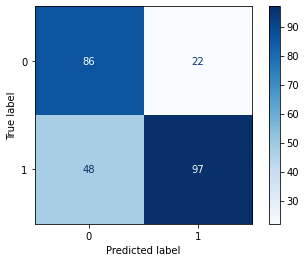

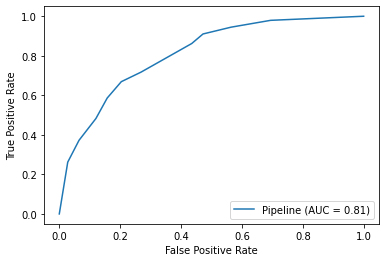

([0.9886], [0.7233], [0.9995], [0.8103])

In [29]:
bag_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=24)))])

bag_clf.fit(X_train, y_train)

bag_result = ut.class_model_evaluation(bag_clf, X_train, y_train, X_val, y_val, use_decision_function='no')
bag_result

>**Comment:** *Bagging*
- Val accuracy 0.7431 is lower than train accuracy 0.9898 = > super overfit
- Model is able to classify the uptrend/downtrend, better than the baseline model
- F1-score (0.71 and 0.80) is better than RF (0.71 and 0.76)
- ROC-score is 0.81 which is relative high

### Boost
- Weak learners: start from simple models but focuse on areas the previous learner got wrong

#### XGBoost
- gradient boost with highest performance

Train
-*-*-*-*-*-*-*-*
accuracy: 0.7536
roc-auc: 0.8695 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.5810
roc-auc: 0.6472


              precision    recall  f1-score   support

           0       0.55      0.10      0.17       108
           1       0.58      0.94      0.72       145

    accuracy                           0.58       253
   macro avg       0.57      0.52      0.45       253
weighted avg       0.57      0.58      0.49       253



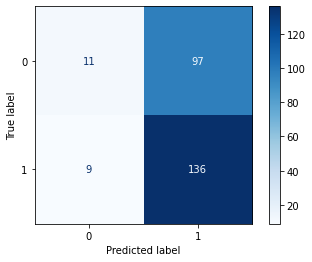

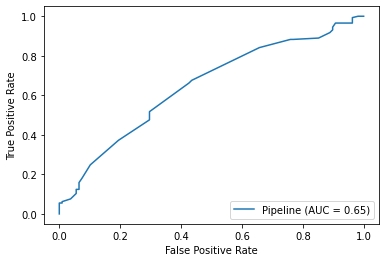

([0.7536], [0.581], [0.8695], [0.6472])

In [30]:
xgb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(random_state=24))])

xgb_clf.fit(X_train, y_train)

xgb_result = ut.class_model_evaluation(xgb_clf, X_train, y_train, X_val, y_val, use_decision_function='no')
xgb_result

>**Comment:** *XGBoost*
- Val accuracy 0.581 is lower than train accuracy 0.7536 = > overfit
- Model is able to classify the uptrend/downtrend, better than the baseline model
- F1-score (0.17 and 0.72) indicates poor performance on classifing downtrend
- ROC-AUC score is 0.65 which is relative worse (better than guessing)

#### AdaBoost
- Similar to Bagging
    - Pros: correct classification's weight is reduced which incorrect classification's weight is increase
    - Cons: continually influencing the distribution of data sampled to train each successive learner

Train
-*-*-*-*-*-*-*-*
accuracy: 1.0000
roc-auc: 1.0000 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.6877
roc-auc: 0.7004


              precision    recall  f1-score   support

           0       0.60      0.79      0.68       108
           1       0.79      0.61      0.69       145

    accuracy                           0.69       253
   macro avg       0.70      0.70      0.69       253
weighted avg       0.71      0.69      0.69       253



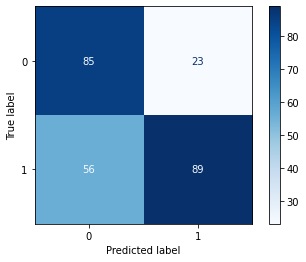

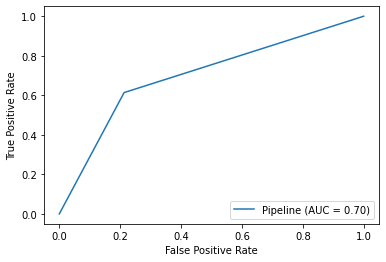

([1.0], [0.6877], [1.0], [0.7004])

In [31]:
ada_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', random_state=24)))])

ada_clf.fit(X_train, y_train)

ada_result = ut.class_model_evaluation(ada_clf, X_train, y_train, X_val, y_val, use_decision_function='no')
ada_result

>**Comment:** *AdaBoost*
- Val accuracy 0.6838 is lower than train accuracy 1.000 = > super overfit
- Model is able to classify the uptrend/downtrend, better than the baseline model
- F1-score (0.68 and 0.69)
- ROC-AUC score is 0.70 which is above average (better than guessing)

#### Gradient Boosting
- Similar to AdaBoost
    - Pros: use loss functino to calculate the distance between residuals and prediction
    - Cons: sensitive learning rates

Train
-*-*-*-*-*-*-*-*
accuracy: 0.7727
roc-auc: 0.8748 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.5731
roc-auc: 0.5531


              precision    recall  f1-score   support

           0       0.50      0.20      0.29       108
           1       0.59      0.85      0.69       145

    accuracy                           0.57       253
   macro avg       0.54      0.53      0.49       253
weighted avg       0.55      0.57      0.52       253



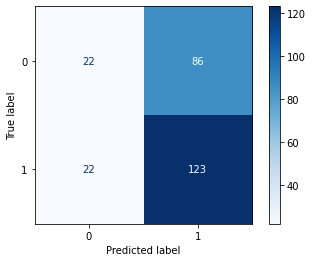

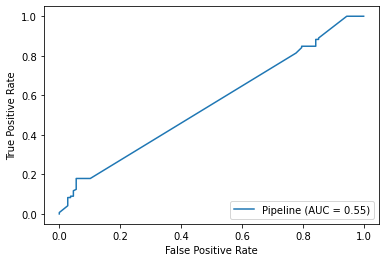

([0.7727], [0.5731], [0.8748], [0.5531])

In [32]:
gb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=24))])

gb_clf.fit(X_train, y_train)

gb_result = ut.class_model_evaluation(gb_clf, X_train, y_train, X_val, y_val, use_decision_function='no')
gb_result

>**Comment:** *Gradient Boost*
- Val accuracy 0.5731 is lower than train accuracy 0.7727 = > overfit
- Model is able to classify the uptrend/downtrend, better than the baseline model
- F1-score (0.29 and 0.69) indicates poor performance on classifing downtrend
- ROC-AUC score is 0.55 which is relative worse (better than guessing)

### SVM
- Find a hyperplane that maximizes the distance between two classes

#### SVC
- C-Support Vector Classification

Train
-*-*-*-*-*-*-*-*
accuracy: 0.7770
roc-auc: 0.9115 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.8498
roc-auc: 0.9302


              precision    recall  f1-score   support

           0       0.79      0.89      0.83       108
           1       0.91      0.82      0.86       145

    accuracy                           0.85       253
   macro avg       0.85      0.85      0.85       253
weighted avg       0.86      0.85      0.85       253



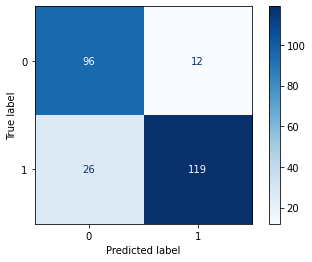

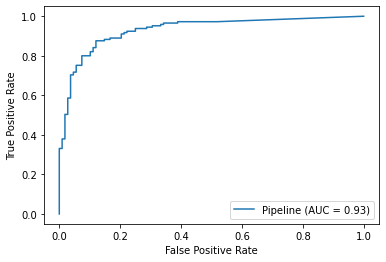

([0.777], [0.8498], [0.9115], [0.9302])

In [33]:
svc_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', SVC(kernel='poly', probability=True, random_state=24))])

svc_clf.fit(X_train, y_train)

svc_result = ut.class_model_evaluation(svc_clf, X_train, y_train, X_val, y_val, use_decision_function='yes')
svc_result

>**Comment:** *SVC*
- Val accuracy 0.8498 is higher than train accuracy 0.777 = > slightly underfit
- Model is able to classify the uptrend/downtrend, better than the baseline model
- F1-score (0.83 and 0.86), higher than previous classifiers
- ROC-AUC score is 0.93 which is relative good

#### NuSVC
- Similar to SVC
- Nu-Support Vector Classification
    - Use a parameter to control the number of support vectors

Train
-*-*-*-*-*-*-*-*
accuracy: 0.8095
roc-auc: 0.9162 

Val
-*-*-*-*-*-*-*-*
accuracy: 0.8617
roc-auc: 0.9292


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       108
           1       0.91      0.84      0.87       145

    accuracy                           0.86       253
   macro avg       0.86      0.87      0.86       253
weighted avg       0.87      0.86      0.86       253



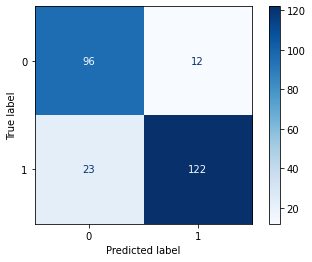

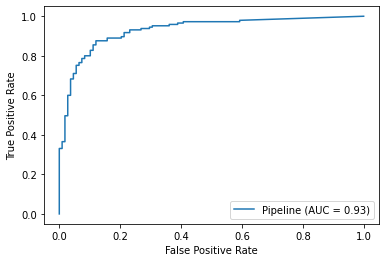

([0.8095], [0.8617], [0.9162], [0.9292])

In [34]:
nusvc_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', NuSVC(kernel='poly', probability=True, random_state=24))])

nusvc_clf.fit(X_train, y_train)

nusvc_result = ut.class_model_evaluation(nusvc_clf, X_train, y_train, X_val, y_val, use_decision_function='yes')
nusvc_result

>**Comment:** * NuSVC*
- Val accuracy 0.8617 is higher than train accuracy 0.8095 = > slightly underfit
- Model is able to classify the uptrend/downtrend, better than the baseline model
- F1-score (0.83 and 0.86), higher than SVC
- ROC-AUC score is 0.93 which is relative good

## IV. Evaluation
- I expect to select a model:
    - with higher accuracy, but not overfit/underfit too much  
    - with fewer false positives and false negatives = > higher f1-score 

In [35]:
# Put all models' evaluation results in a list
model_results = [lg_result,
                 knn_result,
                 rf_result,
                 bag_result,
                 xgb_result,
                 ada_result,
                 gb_result,
                 svc_result,
                 nusvc_result]

In [36]:
# Use pre-defined function to store the all classification model results in a df
model_comp = ut.class_model_comparison(model_results)
model_comp

,classifier,train_acc,val_acc,acc_diff,train_roc_auc,val_roc_auc,roc_auc_diff
0,Logistic Regression,0.5438,0.5731,0.0293,0.7147,0.8933,0.1786
1,KNN,0.8890,0.7708,0.1182,0.9541,0.8355,0.1186
2,Random Forest,1.0000,0.7352,0.2648,1.0000,0.8113,0.1887
3,Bagging,0.9886,0.7233,0.2653,0.9995,0.8103,0.1892
4,XGBoost,0.7536,0.5810,0.1726,0.8695,0.6472,0.2223
5,AdaBoost,1.0000,0.6877,0.3123,1.0000,0.7004,0.2996
6,GradientBoost,0.7727,0.5731,0.1996,0.8748,0.5531,0.3217
7,SVC,0.7770,0.8498,0.0728,0.9115,0.9302,0.0187
8,NuSVC,0.8095,0.8617,0.0522,0.9162,0.9292,0.0130


In [37]:
highest_test_acc = model_comp['val_acc'].max()
print(highest_test_acc)

model_comp.loc[model_comp['val_acc'] == highest_test_acc]

0.8617


,classifier,train_acc,val_acc,acc_diff,train_roc_auc,val_roc_auc,roc_auc_diff
8,NuSVC,0.8095,0.8617,0.0522,0.9162,0.9292,0.0130


- NuSVC is the best classifer with highest accuracy while having relative less FP and FN (f1-score: 0.85, 0.87)

### Holdout Test Set

Test
-*-*-*-*-*-*-*-*
accuracy: 0.9091
roc-auc: 0.9500
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.92      0.92      0.92        12

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22



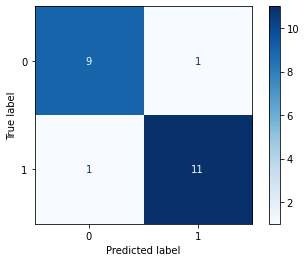

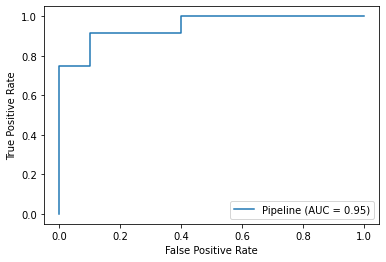

In [38]:
ut.class_evaluate(nusvc_clf, X_test, y_test, use_decision_function='yes')

>**Comment:** *Best NuSVC*
- The test accuracy for holdout test set reaches 0.9091 which is relative high
- Among 22 test samples, only 2 samples were predicted incorrectly

In [39]:
# Save the best classification model
dump(nusvc_clf, open('/content/nusvc.pkl', 'wb'))

# Load the best model (if run in another notebook)
# best = load(open('/content/nusvc.pkl', 'rb'))

In [40]:
# Create a df and store the prediction probability and results
test_result = pd.DataFrame(columns=['true', 'pred', 'uptrend', 'downtrend'])

test_result['true'] = y_test
test_result['pred'] = nusvc_clf.predict(X_test)
test_result['downtrend'] = nusvc_clf.predict_proba(X_test)[:, 0]
test_result['uptrend'] = nusvc_clf.predict_proba(X_test)[:, 1]

test_result

,true,pred,uptrend,downtrend
Date,,,,
2021-05-24,1,1,1.0000,0.0000
2021-05-25,0,0,0.0378,0.9622
2021-05-26,1,1,1.0000,0.0000
2021-05-27,0,0,0.0000,1.0000
2021-05-28,1,1,0.9949,0.0051
2021-06-01,1,1,1.0000,0.0000
2021-06-02,1,1,1.0000,0.0000
2021-06-03,0,0,0.0169,0.9831
2021-06-04,1,0,0.0000,1.0000


In [41]:
# Find the incorrect predictions
test_result.loc[test_result['true'] != test_result['pred']]

,true,pred,uptrend,downtrend
Date,,,,
2021-06-04,1,0,0.0000,1.0000
2021-06-17,0,1,1.0000,0.0000


>**Comment:** *Prediction Probability*
- The prediction probabiliy is 1.0 for both incorrect predictions
- This could be due to the nature of SVM

### Tuning Hyperparameter
- grid search on poly degree
- default is d = 3

In [ ]:
# This took real long time too run...

# Polynomial degree
d = list(range(1, 6, 1))

param_grid = {'classifier__degree': d}

# Grid search
search = GridSearchCV(nusvc_clf, param_grid, cv=5, scoring='f1')
search.fit(X_train, y_train)

print(f"Best parameter: {search.best_params_}\n")

# Evaluate the model with best k
ut.class_model_evaluation(search.best_estimator_, X_train, y_train, X_test, y_test)

## V. Conclusion
- Among analyze 4213 historical data from VNQ, NuSVC classifier was selected among 9 different classifier. The hyperarameter tunning took relative long time to run. For now, current model will be considered as the best NuSVC model
- True holdout test accuracy reaches 0.9091 which is relative high
- There is a small change that the machine will predict incorrectly